In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import tensorflow as tf
import numpy as np

In [2]:
# random seed
tf.random.set_seed(42)

# Load the data

In [3]:
# get absolute path of s1_60m and s2_60m folders
sentinel1_folder = os.path.abspath('s1_60m')
sentinel2_folder = os.path.abspath('s2_60m')

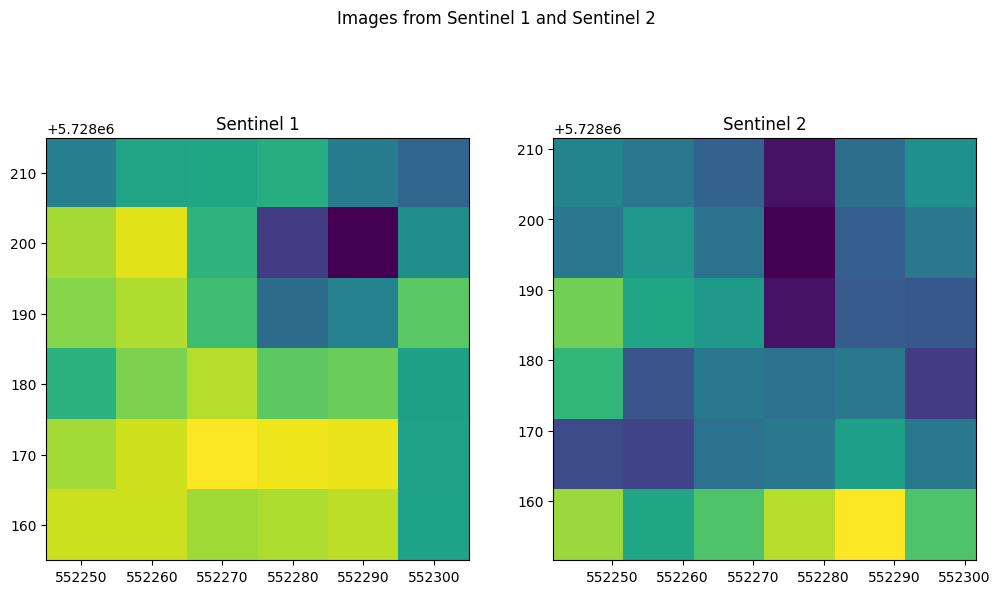

In [4]:
s1_image = rasterio.open(os.path.join(sentinel1_folder, os.listdir(sentinel1_folder)[0]))
s2_image = rasterio.open(os.path.join(sentinel2_folder, os.listdir(sentinel2_folder)[0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
fig.suptitle('Images from Sentinel 1 and Sentinel 2')
show(s1_image, ax=ax1)
ax1.set_title('Sentinel 1')
show(s2_image, ax=ax2)
ax2.set_title('Sentinel 2')
plt.show()

# Preprocess the data

In [5]:
unique_species = []
with open('labels/TreeSatBA_v9_60m_multi_labels.json', 'r') as f:
    labels = pd.read_json(f, typ='series')
    for prediction_list in labels.values:
        for species_prob in prediction_list:
            if species_prob[0] not in unique_species:
                species = species_prob[0]
                unique_species.append(species)
print(unique_species)

['Pseudotsuga', 'Abies', 'Larix', 'Acer', 'Picea', 'Betula', 'Cleared', 'Fagus', 'Quercus', 'Fraxinus', 'Pinus', 'Alnus', 'Populus', 'Prunus', 'Tilia']


In [6]:
def convert_to_dataframe(folder, filenames_file):
    image_vectors = []
    label_values = []
    with open(filenames_file, 'r') as f:
        labels = pd.read_json('labels/TreeSatBA_v9_60m_multi_labels.json', typ='series')
        cnt = 0
        for line in f:
            # if cnt == 10:
            #     break
            filename = line.strip()
            image_path = os.path.join(folder, filename)
            with rasterio.open(image_path) as image:
                # Convert the image to a numpy array
                image_array = np.array(image.read())
                # Flatten and normalize the array
                image_vector = image_array.flatten() / 255.0
                image_vectors.append(image_vector)
                label_values.append(labels[filename])
                
            cnt += 1
    # Convert the list of vectors to a numpy array
    image_vectors = np.array(image_vectors)
    
    # create a dataframe from the numpy array
    df = pd.DataFrame(image_vectors)

    # create a column for each unique_species and fill it with 0 or it's probability if it is present in the label_values list of list (species, probability)
    for species in unique_species:
        df[species] = df.apply(lambda _: 0., axis=1)
    for i in range(len(label_values)):
        for species_prob in label_values[i]:
            species = species_prob[0]
            prob = species_prob[1]
            df.at[i, species] = prob
    return df
    

In [7]:
s1_train_df = convert_to_dataframe(sentinel1_folder, 'train_filenames.lst')
s1_test_df = convert_to_dataframe(sentinel1_folder, 'train_filenames.lst')

In [8]:
s1_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,Betula,Cleared,Fagus,Quercus,Fraxinus,Pinus,Alnus,Populus,Prunus,Tilia
0,-0.020922,-0.015662,-0.015425,-0.014232,-0.021301,-0.024554,-0.005910,-0.002835,-0.013393,-0.029733,...,0.0,0.0,0.00000,0.18421,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.013941,-0.014645,-0.022493,-0.028410,-0.030069,-0.039055,-0.012813,-0.016642,-0.026978,-0.029082,...,0.0,0.0,0.28104,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.028627,-0.023881,-0.024847,-0.024817,-0.024864,-0.032479,-0.030857,-0.026853,-0.029066,-0.028627,...,0.0,0.0,0.97498,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.021111,-0.022445,-0.030760,-0.034735,-0.035164,-0.030187,-0.023455,-0.028201,-0.028643,-0.034349,...,0.0,0.0,0.02866,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.000620,0.004573,-0.004266,-0.008283,-0.004912,-0.002182,0.002477,0.003130,-0.004631,-0.010048,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# drop every column that are in the set() of unique_species
X_train = s1_train_df.drop(columns=unique_species)
y_train = s1_train_df[unique_species]
X_test = s1_test_df.drop(columns=unique_species)
y_test = s1_test_df[unique_species]

In [10]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,-0.020922,-0.015662,-0.015425,-0.014232,-0.021301,-0.024554,-0.005910,-0.002835,-0.013393,-0.029733,...,0.000198,0.000306,0.000301,0.001882,0.000400,0.000439,0.000918,0.000630,0.000401,0.001358
1,-0.013941,-0.014645,-0.022493,-0.028410,-0.030069,-0.039055,-0.012813,-0.016642,-0.026978,-0.029082,...,0.002121,0.002025,0.001843,0.001469,0.001858,0.001918,0.002249,0.002022,0.001789,0.001675
2,-0.028627,-0.023881,-0.024847,-0.024817,-0.024864,-0.032479,-0.030857,-0.026853,-0.029066,-0.028627,...,0.001708,0.003091,0.002995,0.003086,0.003958,0.003644,0.003000,0.003456,0.002820,0.003101
3,-0.021111,-0.022445,-0.030760,-0.034735,-0.035164,-0.030187,-0.023455,-0.028201,-0.028643,-0.034349,...,0.000851,0.001038,0.001564,0.001449,0.001868,0.001321,0.001103,0.001837,0.002739,0.002232
4,-0.000620,0.004573,-0.004266,-0.008283,-0.004912,-0.002182,0.002477,0.003130,-0.004631,-0.010048,...,0.000016,0.000120,0.000543,0.001084,0.002921,0.003085,0.001826,0.001314,0.001374,0.001153


In [11]:
y_train.head()

,Pseudotsuga,Abies,Larix,Acer,Picea,Betula,Cleared,Fagus,Quercus,Fraxinus,Pinus,Alnus,Populus,Prunus,Tilia
0,0.0,0.81464,0.00000,0.0,0.00115,0.0,0.0,0.00000,0.18421,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.71896,0.00000,0.0,0.00000,0.0,0.0,0.28104,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.00556,0.0,0.01946,0.0,0.0,0.97498,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.97134,0.00000,0.0,0.00000,0.0,0.0,0.02866,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.00000,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


Train the model

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# shape 108 columns for each pixel in the image
input_shape = (108,)

In [23]:

model = Sequential([
    Dense(64, activation='relu', input_shape=input_shape),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(unique_species), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
1417/1417 [==============================] - 3s 2ms/step - loss: 227.0158 - accuracy: 0.1409 - val_loss: 2270.4224 - val_accuracy: 0.0474
Epoch 2/50
1417/1417 [==============================] - 3s 2ms/step - loss: 112844.4062 - accuracy: 0.1071 - val_loss: 436870.4688 - val_accuracy: 0.1545
Epoch 3/50
 135/1417 [=>............................] - ETA: 1s - loss: 400698.0938 - accuracy: 0.1116